In [80]:
from openslide import OpenSlide
import os
import numpy as np
import xml.etree.ElementTree as ET
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from time import time
from rgb2hed_v1 import separate_stains
import skimage
from skimage import io
from skimage.measure import label,find_contours,regionprops,regionprops_table
from skimage.morphology import remove_small_objects
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed, cpu_count
from scipy.ndimage import binary_fill_holes

In [81]:
# open svs and xml
tif_src = r'\\kukissd\research\lymphocyte\svs'
fns = os.listdir(tif_src)
fns = [os.path.splitext(fn)[0] for fn in fns]
for fn in fns:
    tif_path = os.path.join(*[tif_src,fn+'.tif'])
    label_src =r'\\kukissd\research\lymphocyte\classified'
    label_path = os.path.join(*[label_src,fn+'.tif'])
    start = time()
    if os.path.exists(tif_path): svs = skimage.io.imread(tif_path)
    print("image loading: {:.2f} sec elapsed".format(time()-start))
    start = time()

    if os.path.exists(label_path): mask = skimage.io.imread(label_path)
    print("label loading: {:.2f} sec elapsed".format(time()-start))

    # find reticular dermis of each section
    start = time()
    mask[mask!=9]=0
    print("mask modification: {:.2f} sec elapsed".format(time()-start))


    region_mask = cv2.resize(mask,dsize=(svs.shape[1],svs.shape[0]))
    region_mask3d = np.repeat(region_mask[:, :, np.newaxis], 3, axis=2)

    region_mask[region_mask!=9]=0
    region_mask[region_mask==9]=1
    area = np.sum(region_mask==1)

    svs[region_mask3d!=9] = 255
    region = svs/255
    region = region.astype(np.float32)

    # RGB to Haematoxylin-Eosin-DAB (HED) color space conversion.
    # Hematoxylin + Eosin + DAB
    start=time()
    rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                             [0.072, 0.990, 0.105],
                             [0.268, 0.570, 0.776]])
    hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
    ihc_hed = separate_stains(region, hed_from_rgb)
    Hema = ihc_hed[:, :, 0]
    print("color deconvolution: {:.2f} sec elapsed".format(time()-start))

    #1 intensity thresholding
    threshold = 0.25
    Hematoxylin = cv2.normalize(Hema, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    np.save(fn+'_H.npy',Hematoxylin)
    # Hematoxylin = np.load(fn+'_H.npy')
    # plt.imshow(Hematoxylin)
    Hematoxylin[Hematoxylin<threshold]=0
    Hematoxylin[Hematoxylin>threshold]=1
    labeled_bw = label(Hematoxylin).astype(np.int64)

    #pre-size filter
    start=time()
    remove_small_objects(labeled_bw,min_size=4,connectivity=1,in_place=True)
    print("{:.2f} sec elapsed".format(time()-start))
    labeled_bw = label((labeled_bw>0)*1).astype(np.int32)

    n = len(np.unique(labeled_bw))
    d = n / area

    print(n,d)

image loading: 18.17 sec elapsed
label loading: 0.13 sec elapsed
mask modification: 0.00 sec elapsed
color deconvolution: 4.86 sec elapsed
0.44 sec elapsed
47697 0.005925902918411211
image loading: 21.84 sec elapsed
label loading: 0.14 sec elapsed
mask modification: 0.01 sec elapsed
color deconvolution: 6.57 sec elapsed
0.54 sec elapsed
39658 0.005171776585719804
image loading: 21.81 sec elapsed
label loading: 0.13 sec elapsed
mask modification: 0.00 sec elapsed
color deconvolution: 6.39 sec elapsed
0.53 sec elapsed
41015 0.005394051117166313
image loading: 21.84 sec elapsed
label loading: 0.14 sec elapsed
mask modification: 0.00 sec elapsed
color deconvolution: 6.38 sec elapsed
0.54 sec elapsed
43522 0.005859072623583461
image loading: 22.65 sec elapsed
label loading: 0.14 sec elapsed
mask modification: 0.01 sec elapsed
color deconvolution: 6.41 sec elapsed
0.54 sec elapsed
50628 0.005861414162838208
image loading: 24.97 sec elapsed
label loading: 0.15 sec elapsed
mask modification: 0

In [82]:
# start=time()
# prop2 = regionprops(labeled_bw)
# area2 = Parallel(n_jobs=-4, prefer="threads")(delayed(np.sum)(x._label_image[x._slice] == x.label) for x in prop2)
# print("{:.2f} sec elapsed".format(time()-start))
# plt.figure(figsize=(10,5))
# plt.hist(area2,100)
# plt.xlim([0,50])

<BarContainer object of 9 artists>

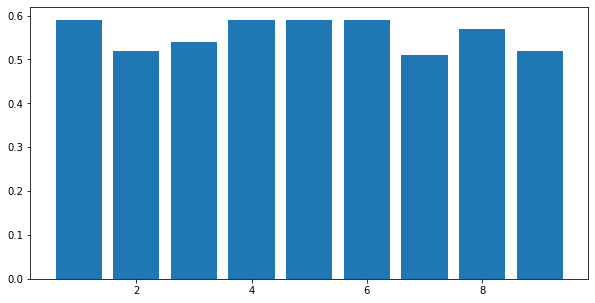

In [87]:
plt.figure(figsize=(10,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9],height=[0.59
,0.52
,0.54
,0.59
,0.59
,0.59
,0.51
,0.57
,0.52

])

In [1]:
import numpy as np

a=[0.59
,0.52
,0.54
,0.59
,0.59
,0.59
,0.51
,0.57
,0.52
]
np.std(a)/np.mean(a)

0.059026025458283046